In [1]:
arches = ['linux-64', 'win-64', 'osx-64', 'noarch', 'linux-ppc64le', 'linux-aarch64']

In [2]:
!rm *.json

rm: cannot remove '*.json': No such file or directory


In [3]:
for a in arches:
    !curl https://conda.anaconda.org/conda-forge/{a}/repodata.json -o repodata-{a}.json
    !curl https://conda.anaconda.org/conda-forge/label/cf201901/{a}/repodata.json -o repodata-cf201901-{a}.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 47.7M  100 47.7M    0     0  11.0M      0  0:00:04  0:00:04 --:--:-- 11.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28.6M    0 28.6M    0     0  9445k      0 --:--:--  0:00:03 --:--:-- 9445k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34.6M  100 34.6M    0     0  11.1M      0  0:00:03  0:00:03 --:--:-- 11.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23.9M    0 23.9M    0     0  9106k      0 --:--:--  0:00:02 --:--:-- 9103k
  % Total    % Received % Xferd  Average Speed   Tim

In [4]:
import glob

In [5]:
import pandas as pd

In [6]:
packages = []
for f in glob.glob('*.json'):
    dat = pd.io.json.loads(open(f).read())
    df = pd.DataFrame(dat['packages'].values())
    df.loc[:, 'filename'] = dat['packages'].keys()
    packages.append(df)
    #packages (df['packages'].items())

In [7]:
df = pd.concat(packages, sort=False, ignore_index=True)

In [8]:
df = df.drop_duplicates(subset=['subdir', 'filename'])

In [9]:
df.loc[:, 'timestamp'] = pd.to_datetime(df.timestamp, unit='ms')

In [10]:
len(df)

257407

Almost 200 thousand artifacts.   Due to us only pulling from master packages that got deprecated during the compiler migration are excluded from
this analysis.

In [11]:
df.timestamp.isnull().sum()

97304

Around half of the packages do not have a creation timestamp in their metadata. thus we kinda have to ignore them

In [12]:
has_ts = df[df.timestamp.notnull()]

In [13]:
has_ts.head()

,timestamp,depends,arch,operatingsystem,target-triplet,size,build_number,name,license,has_prefix,...,app_entry,icon,summary,type,app_type,track_features,filename,noarch,sha256,app_own_environment
0,2018-08-23 11:14:37.650,"[certifi >=2016.09, python >=3.6,<3.7.0a0]",x86_64,linux,x86_64-any-linux,566784.0,0.0,setuptools,MIT,True,...,NaN,NaN,NaN,NaN,NaN,NaN,setuptools-40.2.0-py36_0.tar.bz2,NaN,NaN,NaN
1,2018-07-22 23:10:03.619,[terraform >=0.10],x86_64,linux,x86_64-any-linux,6972261.0,1.0,terraform-provider-consul,MPL 2.0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,terraform-provider-consul-2.1.0-h81701ea_1.tar...,NaN,NaN,NaN
10,2018-10-20 22:48:33.194,"[enum34, matplotlib, numpy, python >=2.7,<2.8....",x86_64,linux,x86_64-any-linux,1258730.0,0.0,flopy,BSD 3-Clause,False,...,NaN,NaN,NaN,NaN,NaN,NaN,flopy-3.2.10-py27h24bf2e0_0.tar.bz2,NaN,NaN,NaN
11,2018-06-14 19:22:56.280,"[msmtools, numpy >=1.8,<1.14, python >=3.6,<3....",x86_64,linux,x86_64-any-linux,493958.0,0.0,bhmm,LGPLv3+,True,...,NaN,NaN,NaN,NaN,NaN,NaN,bhmm-0.6.3-py36_0.tar.bz2,NaN,NaN,NaN
16,2018-10-19 19:01:53.205,"[libgcc-ng >=4.9, numpy >=1.11, pytest-astropy...",x86_64,linux,x86_64-any-linux,6972059.0,0.0,astropy,BSD,True,...,NaN,NaN,NaN,NaN,NaN,NaN,astropy-3.0.5-py37h470a237_0.tar.bz2,NaN,NaN,NaN


In [14]:
fill_val = '2018-03-01'
df_has = df.fillna(pd.to_datetime(fill_val)).sort_values('timestamp').set_index('timestamp')
df_has.loc[:, 'package_count'] = list(range(1, len(df_has)+1))
df_arrival = df_has.groupby(df_has.index.to_period('M')).package_count.max()
df_arrival[df_arrival.index > fill_val].plot(
    title='Number of artifacts across all platforms',
    ylim=(0, df_arrival.max() * 1.1),
    figsize=(16,9)
)

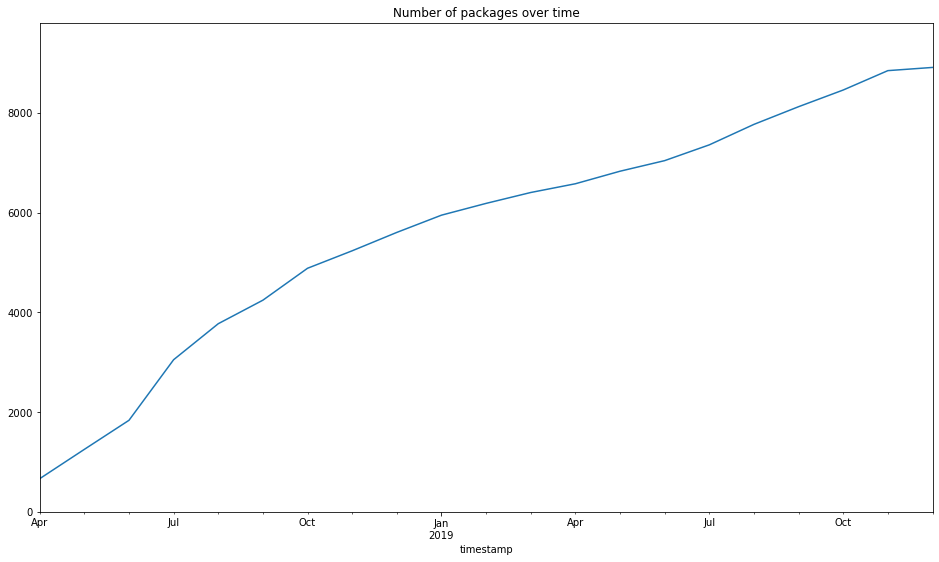

In [15]:
fill_val = '2018-03-01'
x = df.sort_values('timestamp').fillna(pd.to_datetime(fill_val)).groupby(df.name).first()
first_date = pd.DataFrame(x.timestamp).reset_index().set_index('timestamp').sort_index()
first_date.loc[:, 'package_count'] = list(range(1, len(first_date)+1))
df_first = first_date.groupby(first_date.index.to_period('M')).package_count.max()
df_first[df_first.index > fill_val].plot(
    title="Number of packages over time",
    ylim=(0, df_first.max() * 1.1),
    figsize=(16,9)
)

In [16]:
arch_df = {}
for arch in arches:
    fill_val = '2018-03-01'
    x = df.sort_values('timestamp').fillna(pd.to_datetime(fill_val)).loc[df.subdir == arch].groupby(df.name).first()
    first_date = pd.DataFrame(x.timestamp).reset_index().set_index('timestamp').sort_index()
    first_date.loc[:, 'package_count'] = list(range(1, len(first_date)+1))
    df_first = first_date.groupby(first_date.index.to_period('W')).package_count.max()
    arch_df[arch] = df_first

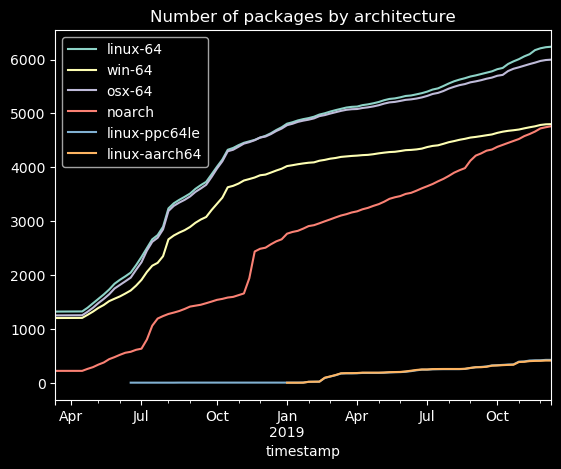

In [24]:
import matplotlib.pyplot as plt
with plt.style.context('dark_background', 
                       'seaborn-talk'
                      ):
    plot_df = pd.DataFrame(arch_df)
    plot_df.ffill()[plot_df.index > fill_val].plot(
        title="Number of packages by architecture",
#         figsize=(16,9)
    )